In [1]:
#import pydracor

import spacy
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from scipy.special import kl_div
from scipy.stats import entropy  # provides Shannon entropy and KL divergence
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
#from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
from nltk import *
import math
import numpy as np    
import copy






libraries:
spacy: tokenize corpus, stopwords,lemmazation, text cleaning, pos tagging
requests: access dracor and opera-guide.ch
beautifulsoup: html sparsing for getting main text and metadata from opera guide
pandas: data storing and manupilation
collections, counter: count words and frequencies
plt: visualisation
seaborn: visualisation
scipy: entropy/kl_div: kl divergence; pdist,quareform:metric distance
sklearn:pca,cosine_similarity
nltk: generate n grams
math
numpy
copy: dictionary munplation

In [2]:
    # Step 1: Initialize corpus from dracor outside the function to aviod repeat loading

from pydracor import  Corpus
sh_corpus = Corpus("gersh")
ger_corpus = Corpus("ger")
ger_meta = ger_corpus.metadata()
sh_meta = sh_corpus.metadata()
print(ger_meta)

[{'num_of_scenes': 22, 'num_of_speakers_unknown': 0, 'wikidata_id': 'Q121463020', 'year_premiered': None, 'digital_source': 'https://books.google.com/books?id=qHNIAQAAMAAJ&amp;pg=PA45', 'num_of_l': 0, 'max_degree_ids': 'fraeulein|rittmeister', 'average_path_length': 1.2, 'average_degree': 4, 'original_source_publisher': 'Vereins-Buchhandlung', 'num_of_segments': 22, 'density': 0.8, 'original_source_number_of_pages': 30, 'normalized_genre': 'Comedy', 'subtitle': 'Original-Lustspiel in einem Akt', 'word_count_stage': 411, 'average_clustering': 0.8444444444444444, 'libretto': False, 'num_of_speakers_female': 3, 'size': 6, 'year_written': None, 'first_author': 'Achat', 'date_premiered': None, 'original_source_pub_place': 'Berlin', 'id': 'ger000637', 'max_degree': 5, 'num_of_acts': 0, 'original_source_year': 1842, 'num_of_p': 518, 'num_of_speakers_male': 3, 'num_of_person_groups': 0, 'title': 'Ein April-Scherz', 'word_count_text': 6888, 'num_of_speakers': 6, 'name': 'achat-ein-april-scherz'

In [3]:
def DCText(corpus_name, filter_kwargs=None):
    from pydracor import DraCor, Corpus

    if corpus_name == "gersh":
        corpus = sh_corpus
        metadata = sh_meta
    else:
        corpus = ger_corpus 
        metadata = ger_meta


    
    
    if filter_kwargs:
        corpus = corpus.filter(**filter_kwargs) #corpus became list with play ids
        #print(corpus)
    else:
        corpus = list(corpus.play_ids())

    data={}
    names,authors,years,ids,spoken_text=[], [], [], [], []

    for i in range(len(corpus)):
        
        #print(i)
        play_meta = next(item for item in metadata if item['id'] == corpus[i])

        if int(play_meta['word_count_text']) < 7400:
            continue

        author_count = len(set(authors))
        if author_count == 0:
            author_count = 1
        if  author_count > 5 and len(names) == 25:  # stop if we already have 5 authors or 5*5 plays
            break 

        author = play_meta['first_author']


        if authors.count(author) >= 10: #each author has maxium 5 plays
            continue
        

        
        authors.append(play_meta['first_author'])
        years.append(play_meta['year_normalized'])
        ids.append(play_meta['id'])
        names.append(play_meta['name'])

    # Step 4: Use correct corpus in the URL
        url = f"https://dracor.org/api/v1/corpora/{corpus_name}/plays/{play_meta['name']}/spoken-text"
        response = requests.get(url)
        spoken_text.append(response.text)
        #print(f"{names} ({corpus_name})\n", spoken_text[i][:30])  # Print preview

    data["names"] =names
    data["authors"]=authors
    data["ids"]=ids
    data["years"]=years
    data["spoken_text"]=spoken_text

    print(len(set(data['authors'])))
    print(len(set(data['names'])))
    return data


In [4]:
titles = frozenset([
    "Romeo und Julia",
    "Der Sturm",
    "Hamlet. Prinz von Dänemark",
    "Maß für Maß",
    "König Lear",
    "Macbeth",
    "Ein Sommernachtstraum",
    "Othello",
    "Wie es euch gefällt",
    "König Johann"
])

sh_data = DCText("gersh",{'title__in':titles})

wa_data=DCText("ger",{"authors__name__icontains": "Wagner, Richard"})

print(sh_data["names"])

1
10
1
9
['der-sturm', 'ein-sommernachtstraum', 'hamlet-prinz-von-daenemark', 'koenig-johann', 'koenig-lear', 'macbeth', 'mass-fuer-mass', 'othello', 'romeo-und-julia', 'wie-es-euch-gefaellt']


fuction1: get text from dracor through pydracor and dracor api
saves all the plays that fit the conditionaly filter in one dictionary: data ={names:[play names to be used later in dracor api],authors:[author names],years:[normolised years],ids:[play ids],spoken_text=[]}
time effeciency: access meta data of the whole german corpus and get spoken text through pydracor takes too much times. solutions to that are first: move the lines of accessing the metadata metadata = corpus.metadata()
out from the funtion so it will only be pulled once; use dracor api to get the spoken text which is way faster beacuse it pulls the text directly through website. doing so saves plenty of runtime in testing and final proformence. to access the desired plays through api requires the play names. playnames are saved in metadata from pycor. thus we can realise the final funtion through a intergration: query the metadata through pydracor and get the list of target playnames, then get the sopken test using dracor api.


In [5]:
#corpus: wagner's other works
urls = ["https://opera-guide.ch/operas/das+liebesverbot/libretto/de/",
      "https://opera-guide.ch/operas/die+feen/libretto/de/",
      "https://opera-guide.ch/operas/rienzi+der+letzte+der+tribunen/libretto/de/"]



def getHTMLSpokenText(url):
    #get play name from url
    name=re.search(r"/operas/([^/]+)/libretto/", url).group(1).replace("+", "-")

    response = requests.get(url)
    response.raise_for_status()



    soup = BeautifulSoup(response.text, "html.parser")

    # Step 1: Extract the div
    div = soup.find("div", class_="col-lg-7 col-12")
    if not div:
        return ""

    # Step 2: Make a clean copy of the div before we modify it
    div_clean = BeautifulSoup(str(div), "html.parser").div

    # Step 3: Remove <i> tags
    for i_tag in div_clean.find_all("i"):
        i_tag.decompose()

    # Step 4: Get the raw text (before removing uppercase lines)
    full_text = div_clean.get_text(separator="\n")


    # Step 5: Trim everything before "ERSTER AKT"
    match = re.search(
    r"\b(?:ERSTER?|I\.)\s+(?:AKT|AUFZUG|SZENE)\b", 
    full_text, 
    re.IGNORECASE
        )
    if match:
        full_text = full_text[match.start():]
    else:
        print("Warning: 'ERSTER AKT' not found.")
        return full_text.strip()  # return full uncut version just in case

    # Step 6: Remove all-uppercase lines
    lines = full_text.splitlines()
    clean_lines = [line for line in lines if not line.strip().isupper() and line.strip() != ""]
    text = "\n".join(clean_lines)

    return text.strip(),name

2.get adiitional plays from opera guide website:
3 plays from wagner which are not predent in Dracor are listed in another website. By html prasing through beautiful soup we can access the texts. 

after close inspection, we can notice that all texts are stored in <div, class_="col-lg-7 col-12"> tags. 
apart from the spoken text we need, there are:
1.there areadditional information before actual text starts(names, summaries), text starts with'FIRST AKT', or'I. Aufzug/SEZNE' in different plays' cases.
2.all the character names are in cap and spereate lines with the spoken text. 
3.stage directions below charater names in <i> tags.

solution:
2. use .decompose() from bf4 to remove all stage direction
1. find"first akt" as a marker through regex and get the main text throuh .start() from bf4 (.decompose() tags before "first akt" element will cause critical problem that destories the whole tree and the function will return "" as result)
3.use regex to find all cap charcters(only names in this case) then remove them.

addtionally to align with previous DCText() function we gather the play names from the url directly at the same time. the result of the meta data can be included manually most effciently.



In [ ]:

#merging additional plays to wagner corpus

for url in urls:
    add_text,add_name = getHTMLSpokenText(url)
    wa_data['spoken_text'].append(add_text)
    wa_data["names"].append(add_name)
    wa_data["authors"].append('Wagner')
    wa_data['ids'].append(str('opera_guide_'+str(urls.index(url))))
wa_data['years'].extend([1835,1888,1842])
#print( wa_data['years'])

In [7]:

def combineData(*datasets):
    """
    Combines multiple dict datasets with the same keys.
    Each key's value from all datasets will be concatenated.
    """
    if not datasets:
        return {}
    
    combined = {}
    for key in datasets[0]:
        combined[key] = []
        for data in datasets:
            combined[key] += data[key]
    return combined


In [8]:
#get control sets fromt the same era
control = frozenset([
    "Schiller",
    "Grillparzer",
    "Hebbel",
])
co_data={'names':[],'authors':[],'ids':[],'years':[],'spoken_text':[]}
for name in control:
    #print(name)
    data= DCText("ger",{"authors__name__icontains":name})
    #print(data)
    co_data=combineData(data,co_data)

    



1
10
1
10
1
10


In [9]:
jon={'names':[],'authors':[],'ids':[],'years':[],'spoken_text':[]}
jon= DCText("ger",{"name__contains":"schlegel-jon"})
co_data=combineData(jon,co_data)
#print(co_data)

1
1


In [10]:

# Tokenize all texts once and store
def tokenizeData(data, nlp):
    data["tokens"] = [nlp(text) for text in data["spoken_text"]]
    return data

# Tokenize both datasets
nlp = spacy.load("de_core_news_sm")

wa_data = tokenizeData(wa_data, nlp)
sh_data = tokenizeData(sh_data, nlp)
co_data =  tokenizeData(co_data,nlp)

In [11]:
#POS Tag N-grams

def getPOS(tokens):
    return [token.pos_ for token in tokens if token.is_alpha] #if token.is_alpha?

def dataPOS(data):
    pos_tags=[]
    for tokens in data['tokens']:
        posed=getPOS(tokens)
        pos_tags.append(posed)

    data['pos_tags']= pos_tags
    return data


co_data = dataPOS(co_data)
wa_data =dataPOS(wa_data)
sh_data =dataPOS(sh_data)
#print(co_data['pos_tags'])


In [12]:
combined_data=combineData(wa_data,sh_data,co_data)
#print(combined_data)

In [13]:

# get min token length for normalisation
def findMin(data):
    return min(len(doc) for doc in data["tokens"])

min_tokens = findMin(combined_data)
print(f"Shortest corpus length (in tokens): {min_tokens}")
min_tokens = findMin(wa_data)
print(f"Shortest corpus length (in tokens): {min_tokens}")
min_tokens = findMin(sh_data)
print(f"Shortest corpus length (in tokens): {min_tokens}")

Shortest corpus length (in tokens): 7531
Shortest corpus length (in tokens): 7531
Shortest corpus length (in tokens): 21400


normoalise corpus lenth:Findmin() find out minium lenth in the entrie corpus. all the plays will be trimed into same lenth to aviod bias when nesseary.

function words kl divergence:
1.get all word count from every play/ every author
2.normalized them so that the components summed to 1
2.took each of these normalized vectors to be the feature vector for the corresponding author/play
4.apply kl then similarity to dataframe.
5.visuisation in heatmap

In [ ]:
#part1: funtional words
# Function Word Frequencies




def getFunWord(text):
    return str(" ".join([token.lemma_ for token in text[:min_tokens] if token.is_stop]).lower()).split()


'\'\'\n#spacy dont have a stop word list\ndef getAllFunLsit(data):\n    allFunList=[]\n    for text in data["tokens"]:\n        text =getFunWord(text)\n        for word in text:\n            if word not in allFunList:\n                allFunList.append(word)\n    return allFunList\n\nall_fun_list = getAllFunLsit(combined_data)\n'

map out all the function words in a play, stored them as list , each word is one element, and only the function words with in the minlen will be gathered.
spacy doesnt have a fix stopword list.

In [15]:

def corpusFreq(data):
    corpus_count={}
    for name, tokens in zip(data["names"], data["tokens"]):
        fun_Words =getFunWord(tokens)
        counts = Counter(fun_Words)
        print(name,counts)

        corpus_count[name]=counts
    return corpus_count
corpus_count= corpusFreq(combined_data)
print(corpus_count)


wagner-das-rheingold Counter({'der': 544, 'ich': 196, 'du': 170, 'zu': 146, 'und': 131, 'mir': 100, 'sein': 100, 'ihr': 84, 'nicht': 82, 'in': 77, 'wie': 72, 'mich': 67, 'sie': 61, 'dir': 56, 'sich': 56, 'dich': 54, 'so': 52, 'was': 51, 'er': 49, 'doch': 49, 'nun': 47, 'euch': 45, 'mit': 43, 'uns': 41, 'ihn': 40, 'mein': 38, 'wer': 35, 'ein': 35, 'es': 34, 'dein': 34, 'wir': 34, 'nur': 33, 'von': 29, 'wohl': 28, 'daß': 27, 'um': 24, 'auf': 24, 'dort': 23, 'noch': 23, 'an': 22, 'durch': 21, 'denn': 21, 'ihm': 20, 'nach': 20, 'für': 20, 'alle': 20, 'da': 19, 'hier': 19, 'vor': 18, 'aus': 18, 'macht': 18, 'als': 16, 'sollen': 15, 'ohne': 15, 'wollen': 14, 'her': 14, 'müssen': 14, 'gut': 13, 'auch': 13, 'wo': 13, 'leicht': 12, 'dann': 12, 'mehr': 12, 'wieder': 11, 'jetzt': 11, 'willst': 10, 'kein': 10, 'dieser': 10, 'immer': 10, 'eigen': 10, 'selbst': 10, 'nie': 10, 'nichts': 10, 'allein': 9, 'schon': 9, 'bei': 9, 'dank': 8, 'bis': 8, 'zurück': 8, 'acht': 7, 'gern': 6, 'wenn': 6, 'viel': 6

corpus_freq()returns a nested dictionary, key is play name and value will be a collection of funtion words and thier counts in value pairs. the countering and storing the values are easily done by counter() from collections.

In [42]:


df_count = pd.DataFrame.from_dict(corpus_count, orient='index').fillna(0) #Builds  count matrix, row = play, column = a word/feature.
#KL involves log(P/Q). If P>0 and Q=0, KL explodes to ∞. Smoothing prevents division by zero and infinite values. but if .fillna(ep), all the counts will be 1 eps short.
df_count['authors']=combined_data['authors']
df_avg=df_count.groupby(['authors']).sum()
eps=1e-8
df_avg += eps
df_prob = df_avg.div(df_avg.sum(axis=1), axis=0)

#L1-normalize to make probabilities
#Divide by the sum so the vector sums to 1.


print(df_prob)

                   du        zu    allein       mit       ich      zwei  \
authors                                                                   
Grillparzer  0.026622  0.021576  0.002966  0.012431  0.046260  0.000614   
Hebbel       0.024873  0.022395  0.001311  0.009994  0.054150  0.000440   
Schiller     0.015642  0.027190  0.001271  0.013391  0.041130  0.000630   
Schlegel     0.024886  0.030494  0.002687  0.017058  0.038322  0.000584   
Shakespeare  0.018203  0.028310  0.000954  0.014062  0.047664  0.000977   
Wagner       0.034648  0.031775  0.001596  0.010854  0.060469  0.000282   

                  wie       vor       dir       mir  ...          jene  \
authors                                              ...                 
Grillparzer  0.011852  0.003651  0.006570  0.014711  ...  2.363228e-05   
Hebbel       0.013660  0.004956  0.008991  0.015073  ...  1.024013e-13   
Schiller     0.010743  0.003791  0.004981  0.014592  ...  1.166466e-13   
Schlegel     0.016824  0.0044

next setp will be the first data stastical method on funtionword frequency. kl direvence .
first prepare the data in data frame. Builds  count matrix, row = play, column = a word/feature. we wan to see the performance on author level, so we group all the texts by author name and sum up all the word counts from single plays. 
#KL involves log(P/Q). If P>0 and Q=0, KL explodes to ∞. Smoothing prevents division by zero and infinite values. but if .fillna(ep), all the counts will be 1 eps short.
second, different author has diffrenet total number of plays and to calculate kl , datas must sum up to 1. 
so Division makes each row sum to 1 → normalized probability distribution of words per author.

In [17]:

def kl(df):
    index = df.index
    kl_matrix = pd.DataFrame(index=index, columns=index, dtype=float)
    for a1 in index:
        for a2 in index:
            p = df.loc[a1]
            q = df.loc[a2]
            kl_matrix.loc[a1, a2] = kl_div(p, q).sum() # KL(a1 || a2)
    return kl_matrix

kl_matrix = kl(df_prob)
print(kl_matrix)


authors      Grillparzer    Hebbel  Schiller  Schlegel  Shakespeare    Wagner
authors                                                                      
Grillparzer     0.000000  0.089791  0.095643  0.198614     0.065912  0.136386
Hebbel          0.093244  0.000000  0.075928  0.265658     0.071801  0.192007
Schiller        0.096061  0.075717  0.000000  0.224402     0.057900  0.182849
Schlegel        0.100995  0.120143  0.100411  0.000000     0.115132  0.168805
Shakespeare     0.084146  0.079344  0.060524  0.257449     0.000000  0.182004
Wagner          0.137629  0.180994  0.185979  0.223153     0.163667  0.000000


KL with spicy:
https://stackoverflow.com/questions/63369974/3-functions-for-computing-relative-entropy-in-scipy-whats-the-difference

authors      Grillparzer    Hebbel  Schiller  Schlegel  Shakespeare    Wagner
authors                                                                      
Grillparzer     1.000000  0.835619  0.825896  0.672181     0.876496  0.761266
Hebbel          0.829868  1.000000  0.859112  0.587831     0.866232  0.681122
Schiller        0.825206  0.859474  1.000000  0.638392     0.890653  0.693712
Schlegel        0.817104  0.786403  0.818058  1.000000     0.794325  0.713473
Shakespeare     0.845107  0.853262  0.885992  0.597562     1.000000  0.694886
Wagner          0.759376  0.696291  0.689383  0.639988     0.720842  1.000000


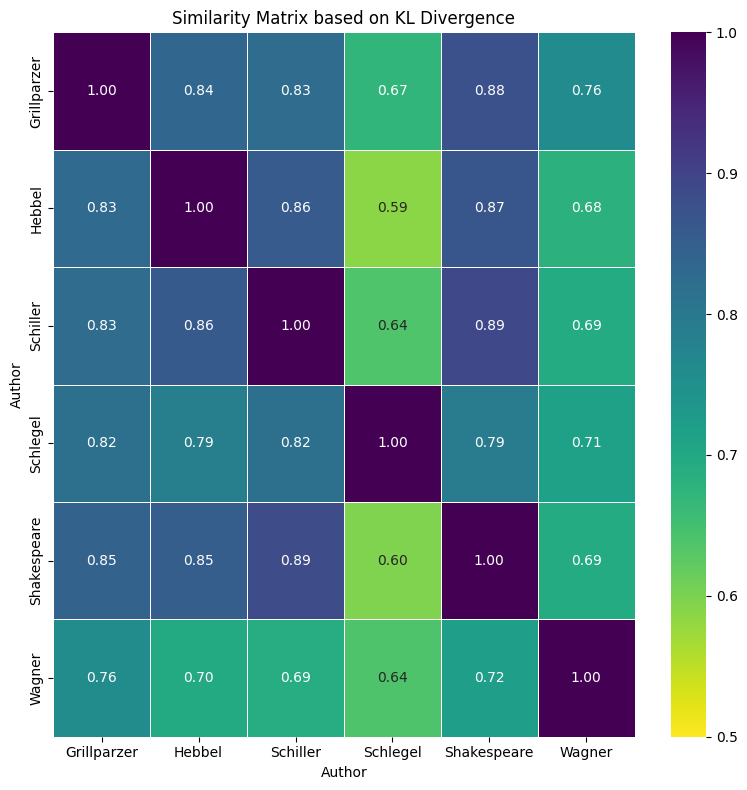

In [34]:
import numpy as np
import pandas as pd

def sim(df):
    # sigma
    sigma = 0.5

    # Ähnlichkeitsmatrix berechnen
    similarity_matrix = np.exp(-df / sigma)

    # Optional: als DataFrame mit gleichen Indizes und Spalten wie kl_matrix
    similarity_matrix = pd.DataFrame(similarity_matrix, index=df.index, columns=df.columns)
    return similarity_matrix

similarity_matrix = sim(kl_matrix)
print(similarity_matrix)


# heatmap visulisation:
#print(df_kl)
plt.figure(figsize=(8, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='viridis_r', fmt=".2f", linewidths=.5,vmin=0.5, vmax=1)
plt.title('Similarity Matrix based on KL Divergence')
plt.xlabel('Author')
plt.ylabel('Author')
plt.tight_layout()
plt.show()


convert kl values to similarities according to ...
the value will be in [0,1], the higher the similar.

In [19]:
#kl divergence of each plays
df =df_count.select_dtypes(include=['number'])
df += eps
df_all_prob = df.div(df.sum(axis=1), axis=0)

#print(df_all_prob)


kl_matrix_all = kl(df_all_prob)
#print(kl_matrix)

similarity_matrix_all= sim(kl_matrix_all)

plt.figure(figsize=(80, 80))
sns.heatmap(similarity_matrix_all, annot=True, cmap='viridis_r', fmt=".2f", linewidths=.5,vmin=0, vmax=1)
plt.title('Similarity Matrix based on KL Divergence')
plt.xlabel('plays')
plt.ylabel('palys')
plt.tight_layout()
plt.show()





pos uni gram:
1.extract all pos for each play
2.group df by author and calulate the means for each pos tag frequency under same author
3.

In [20]:
#Feature Extraction: POS Tag Frequencies and N-grams

# Function to calculate normalized POS tag frequencies (unigrams)
def calculate_pos_frequencies(pos):
    pos_count = Counter(pos)
    total_tags = sum(pos_count.values())
    # Normalize to get proportions/percentages
    pos_freq = {tag: count / total_tags for tag, count in pos_count.items()}
    return pos_freq

# Function to calculate normalized POS tag N-gram frequencies
def calculate_pos_ngrams(pos, n):
    pos_ngrams = list(ngrams(pos, n))
    ngram_count = Counter(pos_ngrams)
    total_ngrams = sum(ngram_count.values())
    # Normalize to get proportions/probabilities
    ngram_freq = {ngram: count / total_ngrams for ngram, count in ngram_count.items()}
    return ngram_freq

# Store calculated features for each play
pos_frequencies = {}
pos_bigrams = {}
pos_trigrams = {}

for i, name in enumerate(combined_data["names"]):
    pos_tags = combined_data["pos_tags"][i]
    pos_frequencies[name] = calculate_pos_frequencies(pos_tags)
    pos_bigrams[name] = calculate_pos_ngrams(pos_tags, n=2)
    pos_trigrams[name] = calculate_pos_ngrams(pos_tags, n=3)


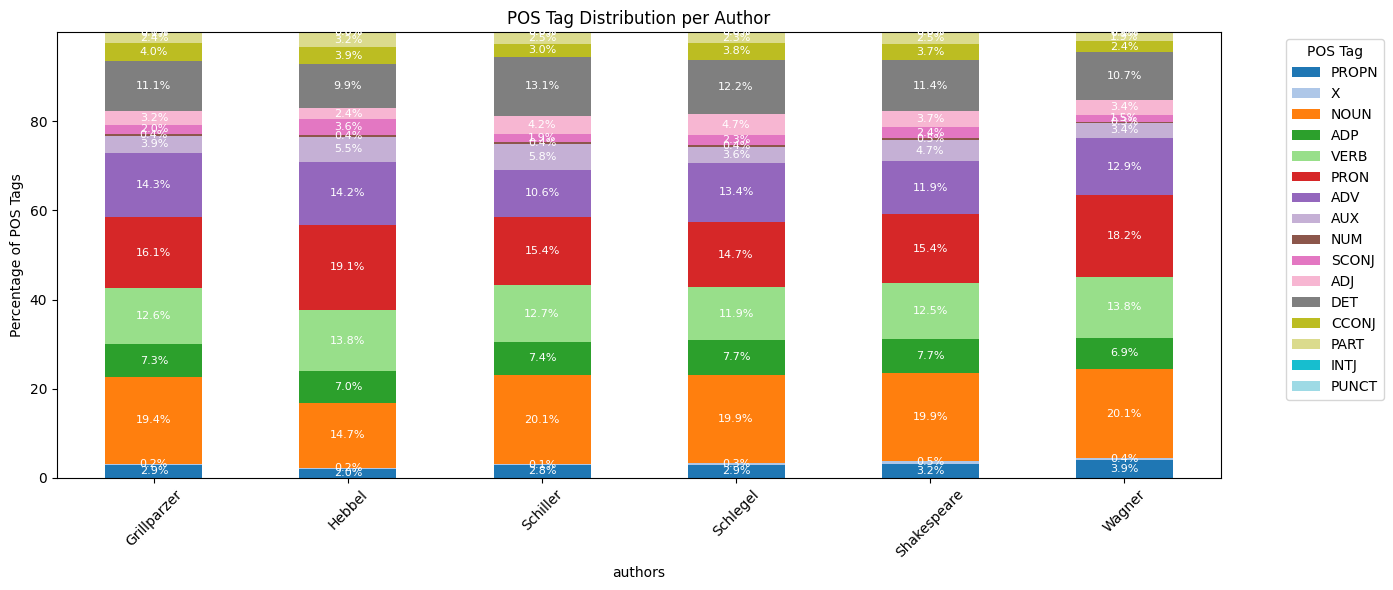

In [21]:

# Convert  frequency dictionary to a DataFrame
tag_df = pd.DataFrame.from_dict(pos_frequencies, orient="index").fillna(0.0)
tag_df['authors'] = combined_data['authors']


author_means = tag_df.groupby("authors").mean().reset_index()
# Drop non-POS columns first if needed
pos_columns = [col for col in author_means.columns if col not in ['authors']]

# Calculate row-wise percentage for each author
author_means_percentage = author_means.copy()
author_means_percentage[pos_columns] = author_means_percentage[pos_columns].div(
    author_means_percentage[pos_columns].sum(axis=1), axis=0
) * 100  # multiply by 100 to get percentage

#print(author_means_percentage)




pos_columns = [col for col in author_means_percentage.columns if col != 'authors']
df = author_means_percentage.set_index('authors')[pos_columns]

fig, ax = plt.subplots(figsize=(14, 6))

# stacked bar plot
bars = df.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')

# annotate each segment with percentage
for i, author in enumerate(df.index):
    bottom = 0
    for pos in pos_columns:
        val = df.loc[author, pos]
        if val > 0:
            ax.text(
                i, 
                bottom + val/2,           # position in the middle of the segment
                f"{val:.1f}%",            # show one decimal
                ha='center', va='center',
                fontsize=8,
                color='white'             # adjust color for contrast
            )
            bottom += val

plt.ylabel("Percentage of POS Tags")
plt.title("POS Tag Distribution per Author")
plt.xticks(rotation=45)
plt.legend(title="POS Tag", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




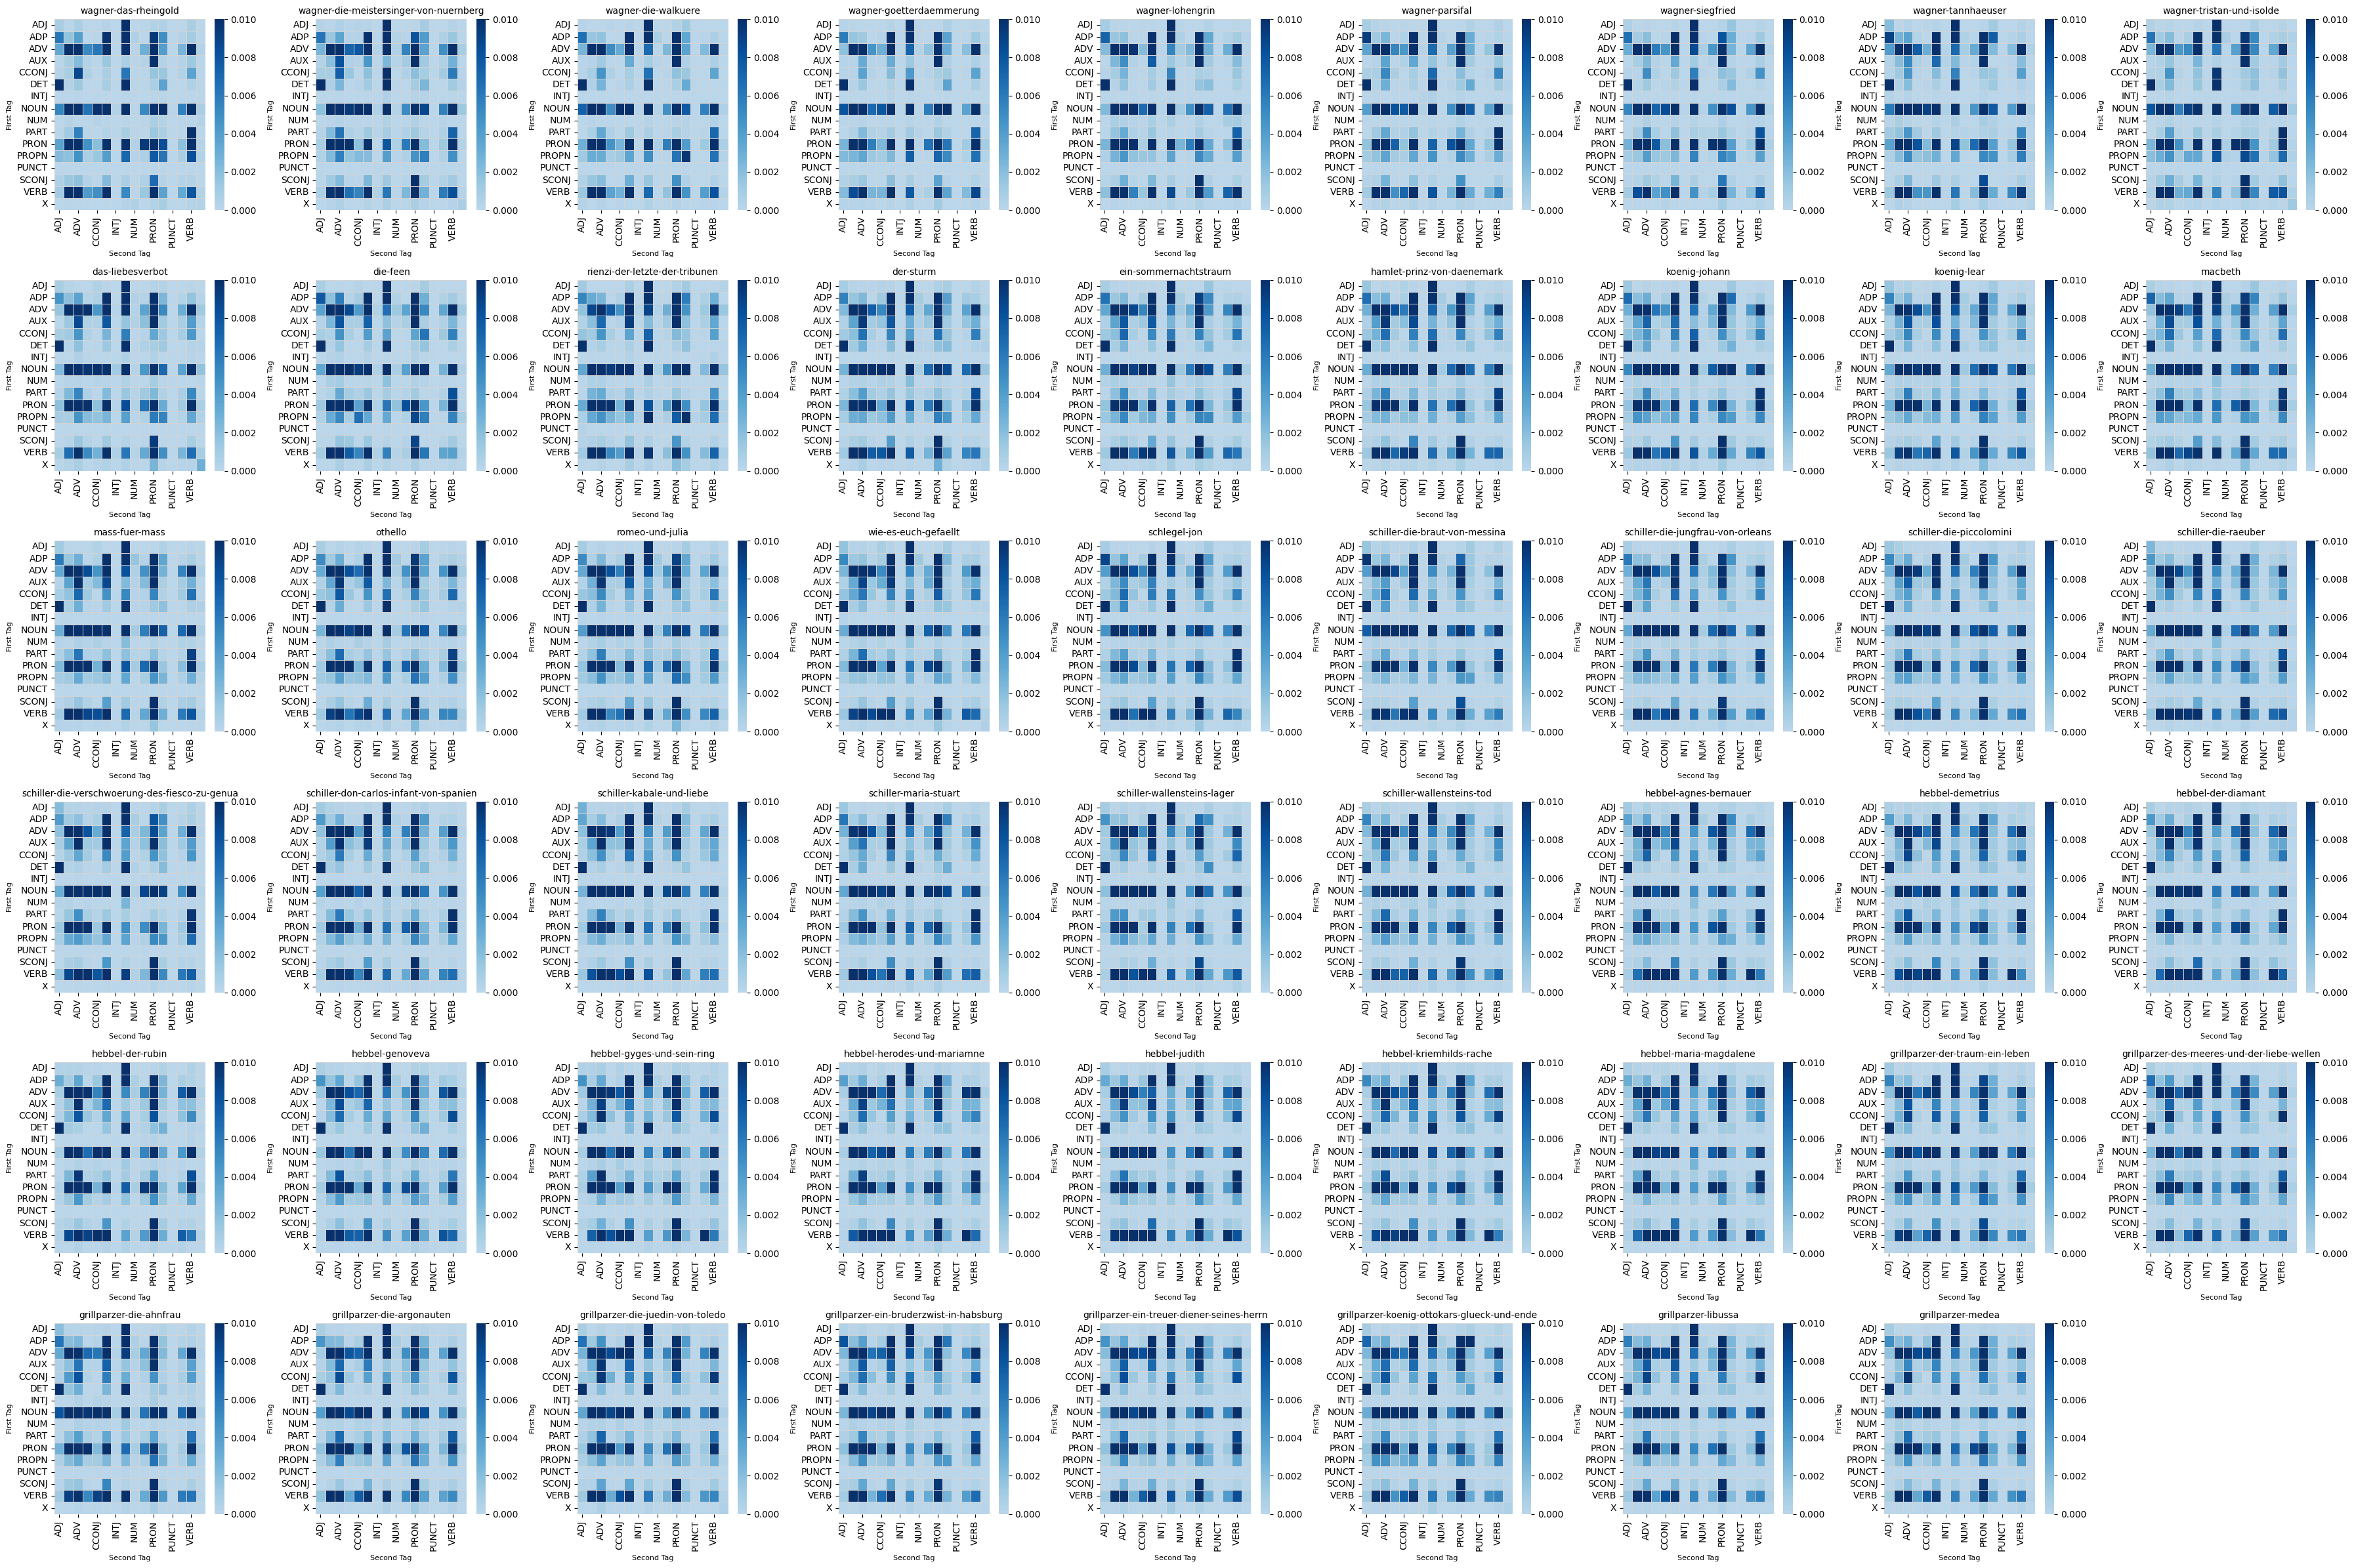

In [22]:
# Prepare data for heatmaps (bigram frequency matrices)
# We'll create a heatmap for each author.
# First, get a consolidated list of all unique POS tags to ensure consistent matrix dimensions.
import matplotlib.pyplot as plt
import seaborn as sns


all_unique_tags = sorted(list(set(tag for tags_list in combined_data["pos_tags"] for tag in tags_list)))

n_authors = len(combined_data["names"])
n_rows, n_cols = 6, 9  # 6x9 grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))  # adjust size as needed

# Flatten axes array for easy iteration
axes = axes.flatten()

for ax, name in zip(axes, combined_data["names"]):
    bigram_freqs = pos_bigrams[name]

    # Create a matrix for the heatmap
    bigram_matrix = pd.DataFrame(0.0, index=all_unique_tags, columns=all_unique_tags)
    for (tag1, tag2), freq in bigram_freqs.items():
        if tag1 in all_unique_tags and tag2 in all_unique_tags:
            bigram_matrix.loc[tag1, tag2] = freq
    #print(bigram_matrix)
    # Plot heatmap on the specific axis
    sns.heatmap(bigram_matrix, annot=False, fmt=".2f", cmap="Blues",
                linewidths=.5, linecolor='lightgray', cbar=True, ax=ax, vmin=0, vmax=0.01, center=0.003)
    ax.set_title(f'{name}', fontsize=10)
    ax.set_xlabel('Second Tag', fontsize=8)
    ax.set_ylabel('First Tag', fontsize=8)

# Turn off any unused subplots
for i in range(len(combined_data["names"]), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [23]:
# bi gram z score

# Gather all unique bigrams
import pandas as pd
import numpy as np
#print(pos_bigrams)
# Gather all unique bigrams and convert to a list
all_bigrams=[]
for text_name, bigram_counts in pos_bigrams.items():
    for bigram, freq in bigram_counts.items():
        # bigram is a tuple like ('AUX', 'PRON')
        bi_str = f"{bigram[0]}-{bigram[1]}"  # convert tuple to string
        if bi_str not in all_bigrams:
            all_bigrams.append(bi_str)
        #print(bi_str, freq)

#print(all_bigrams)
# Create a DataFrame: rows=texts, columns=bigrams
df = pd.DataFrame(index=pos_bigrams.keys(), columns=all_bigrams).fillna(0.0)


for text, counts in pos_bigrams.items():
    for bigram, freq in counts.items():
        bi_str = f"{bigram[0]}-{bigram[1]}"  # convert tuple to string
        df.loc[text, bi_str] = freq

#print(df)
# Compute z-scores for each bigram
z_scores = df.copy()
z_scores['authors']=combined_data['authors']
for col in df.columns:
    mean = df[col].mean()
    std = df[col].std(ddof=0)  # population std; use ddof=1 for sample std
    if std > 0:
        z_scores[col] = (df[col] - mean) / std
    else:
        z_scores[col] = 0.0  # if no variance, z-score is zero

print(z_scores)

R:\user_temp\TEMP\TEMP\ipykernel_18148\1425383973.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.DataFrame(index=pos_bigrams.keys(), columns=all_bigrams).fillna(0.0)


                                                 PROPN-X    X-NOUN  \
wagner-das-rheingold                            1.083604 -0.441908   
wagner-die-meistersinger-von-nuernberg         -0.755285  1.258846   
wagner-die-walkuere                             0.660543  0.271767   
wagner-goetterdaemmerung                        0.828736  0.972046   
wagner-lohengrin                               -0.400673  0.585995   
wagner-parsifal                                 0.483127 -0.344633   
wagner-siegfried                               -0.147212 -1.236904   
wagner-tannhaeuser                              1.768486  2.248722   
wagner-tristan-und-isolde                       1.434505 -0.592263   
das-liebesverbot                                1.376188  0.882988   
die-feen                                        3.259150  0.151386   
rienzi-der-letzte-der-tribunen                  1.735957  0.676568   
der-sturm                                      -0.073161 -0.798072   
ein-sommernachtstrau

In [24]:
z_scores = z_scores.reset_index(drop=True)  # drop old index
z_scores['text'] = combined_data['names']   # create a proper text/play column
print(z_scores.columns)


Index(['PROPN-X', 'X-NOUN', 'NOUN-PROPN', 'PROPN-NOUN', 'NOUN-NOUN',
       'NOUN-ADP', 'ADP-NOUN', 'NOUN-X', 'X-PROPN', 'X-X',
       ...
       'VERB-PUNCT', 'PUNCT-DET', 'PUNCT-SCONJ', 'ADV-PUNCT', 'PUNCT-ADV',
       'CCONJ-INTJ', 'INTJ-X', 'X-INTJ', 'authors', 'text'],
      dtype='object', length=235)


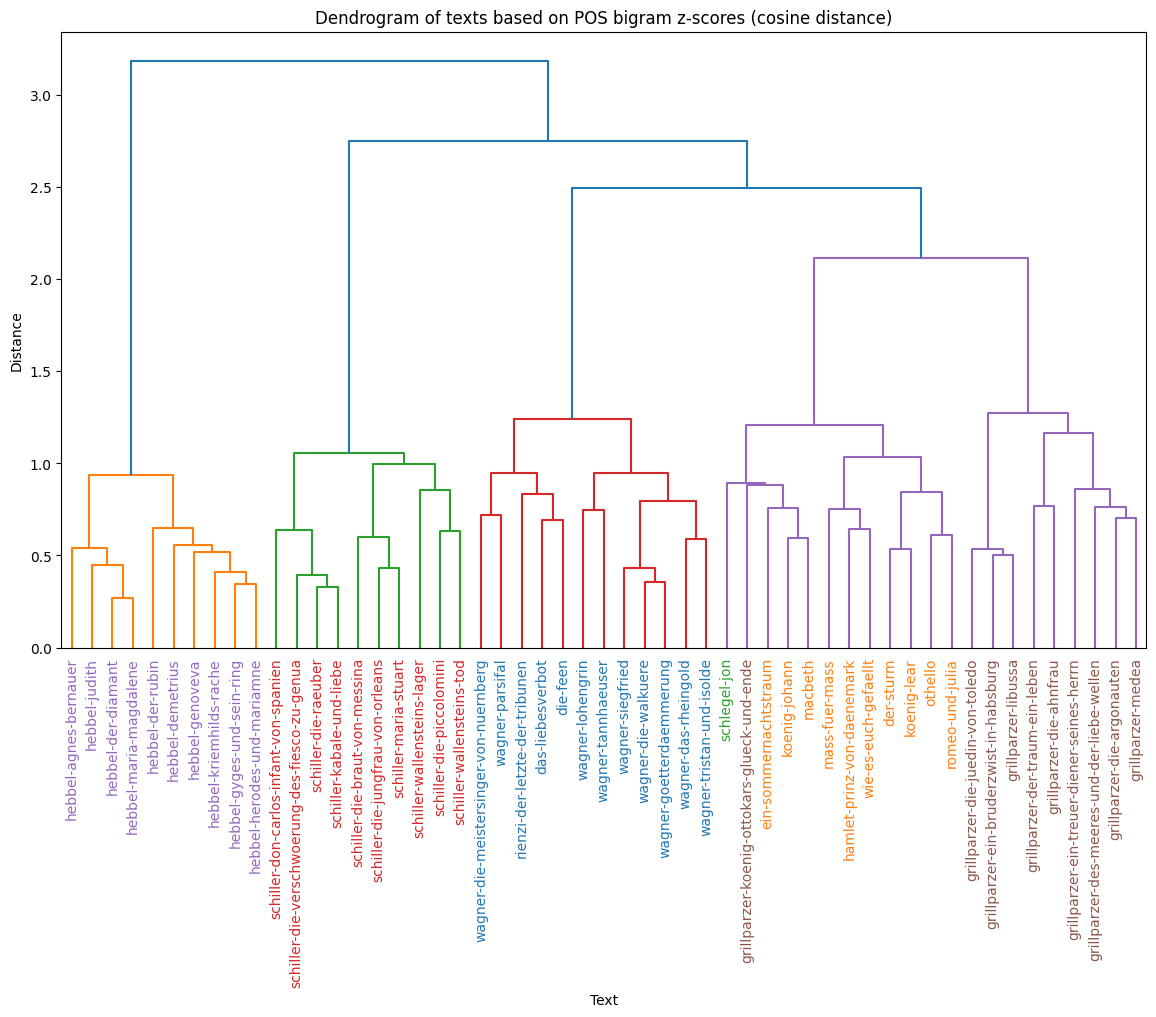

In [37]:
import pandas as pd

import matplotlib.pyplot as plt

# Select bigram columns
bigram_cols = [col for col in z_scores.columns if '-' in col]
X = z_scores[bigram_cols].fillna(0)

# Compute cosine similarity
sim_matrix = cosine_similarity(X)

# Convert to distance
dist_matrix = 1 - sim_matrix

# Ensure diagonal is exactly zero
np.fill_diagonal(dist_matrix, 0)

# Flatten for linkage
dist_condensed = squareform(dist_matrix)


# Hierarchical clustering
Z = linkage(dist_condensed, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 8))
dendro = dendrogram(
    Z,
    labels=z_scores['text'].values,
    leaf_rotation=90,
    leaf_font_size=10,
)

# Color leaves by author
ax = plt.gca()
author_list = z_scores['authors'].tolist()
unique_authors = z_scores['authors'].unique()
colors = plt.cm.tab10(range(len(unique_authors)))
author_colors = dict(zip(unique_authors, colors))

for tick_label in ax.get_xticklabels():
    text = tick_label.get_text()
    author = z_scores.loc[z_scores['text'] == text, 'authors'].values[0]
    tick_label.set_color(author_colors[author])

plt.title("Dendrogram of texts based on POS bigram z-scores (cosine distance)")
plt.xlabel("Text")
plt.ylabel("Distance")
plt.show()


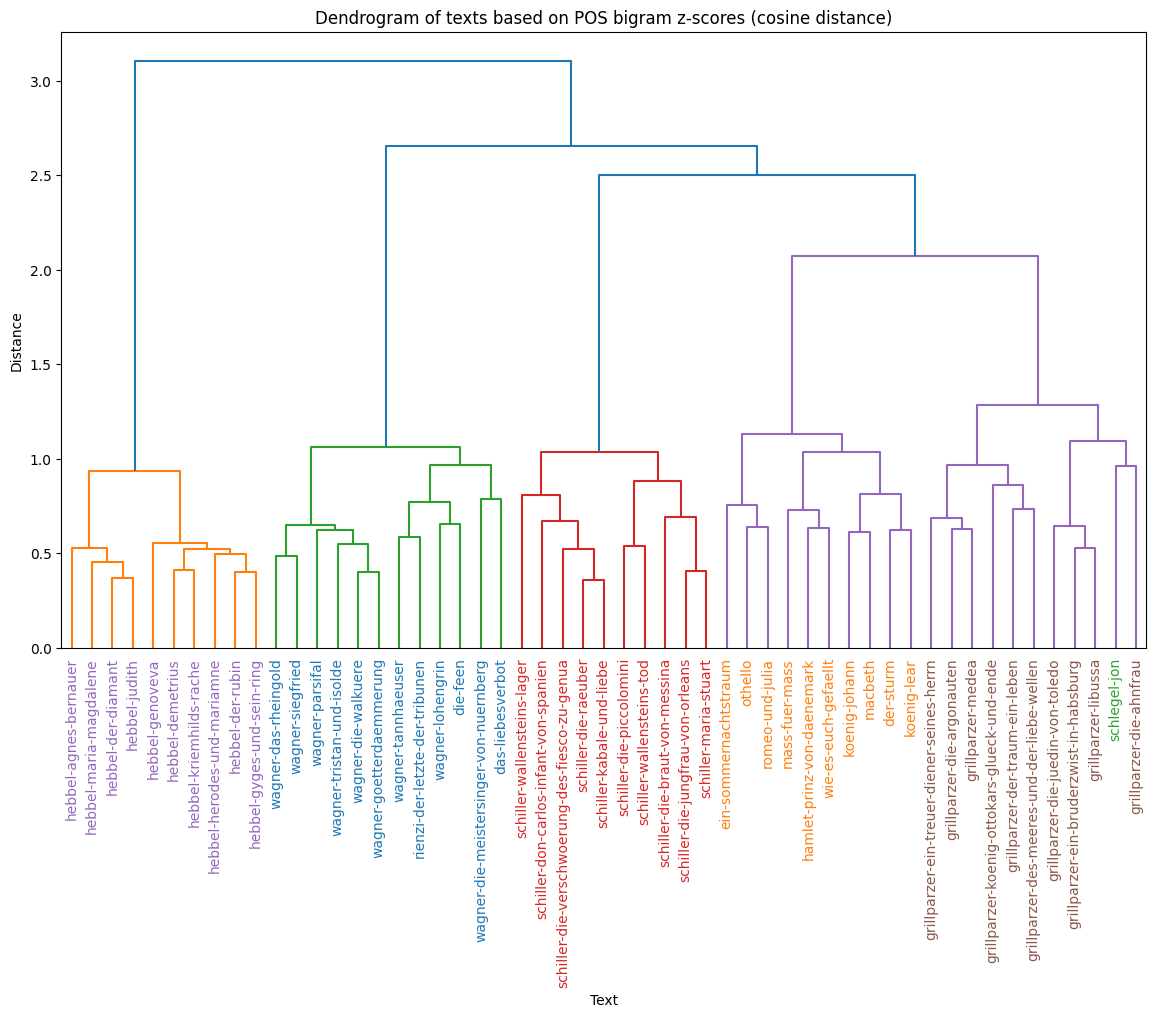

In [ ]:
'''
#setting a threshhold of 2 for z score, the result is the same

#print(X)
z_filtered = X.copy()
z_filtered = z_filtered.mask(z_filtered.abs() >= 2,0)


# Compute cosine similarity and distance
sim_matrix = cosine_similarity(z_filtered)
dist_matrix = 1 - sim_matrix

# Ensure diagonal is exactly zero
np.fill_diagonal(dist_matrix, 0)

# Flatten for linkage
dist_condensed = squareform(dist_matrix)


# Hierarchical clustering
Z = linkage(dist_condensed, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 8))
dendro = dendrogram(
    Z,
    labels=z_scores['text'].values,
    leaf_rotation=90,
    leaf_font_size=10,
)

# Color leaves by author
ax = plt.gca()
author_list = z_scores['authors'].tolist()
unique_authors = z_scores['authors'].unique()
colors = plt.cm.tab10(range(len(unique_authors)))
author_colors = dict(zip(unique_authors, colors))

for tick_label in ax.get_xticklabels():
    text = tick_label.get_text()
    author = z_scores.loc[z_scores['text'] == text, 'authors'].values[0]
    tick_label.set_color(author_colors[author])

plt.title("Dendrogram of texts based on POS bigram z-scores (cosine distance)")
plt.xlabel("Text")
plt.ylabel("Distance")
plt.show()
'''


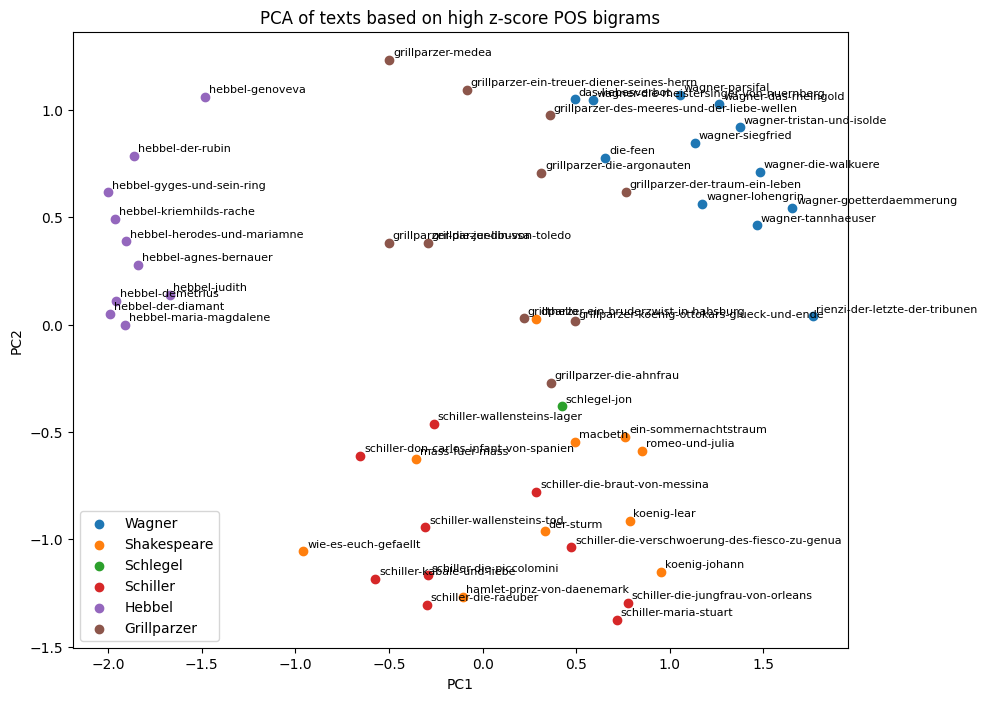

In [ ]:
'''''
#PCA for cos_sim

# sim_matrix: cosine similarity matrix (numpy array)
# z_scores['text'] contains text names
# z_scores['authors'] contains authors

# Convert similarity to distance for PCA: distance = 1 - similarity
dist_matrix = 1 - sim_matrix

# Apply PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(dist_matrix)

# Make a DataFrame for plotting
df_plot = pd.DataFrame({
    'PC1': coords[:, 0],
    'PC2': coords[:, 1],
    'text': z_scores['text'],
    'author': z_scores['authors']
})

# Scatter plot
plt.figure(figsize=(10, 8))
for author in df_plot['author'].unique():
    subset = df_plot[df_plot['author'] == author]
    plt.scatter(subset['PC1'], subset['PC2'], label=author)

# Add annotations (play names) for each point
for i, row in df_plot.iterrows():
    plt.text(row['PC1'] + 0.02, row['PC2'] + 0.02, row['text'], fontsize=8)  

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of texts based on high z-score POS bigrams")
plt.legend()
plt.show()
'''


In [28]:


# ---------- 1. Combine POS uni-, bi-, and trigram frequencies ----------
X = {}
for name in combined_data['names']:
    X[name] = copy.deepcopy(pos_frequencies[name])      # Start with unigrams
    X[name].update(pos_bigrams[name])                   # Add bigrams
    X[name].update(pos_trigrams[name])                  # Add trigrams

# ---------- 2. Normalize keys: turn tuples into strings ----------
def string_key(k):
    if isinstance(k, str):
        return k
    return ">".join(k)  # Join POS tags with '>' to mark order

X_str_keys = {}
for name, feats in X.items():
    X_str_keys[name] = {string_key(k): v for k, v in feats.items()}

# ---------- 3. Build DataFrame ----------
df_features = pd.DataFrame.from_dict(X_str_keys, orient="index").fillna(0)

print("Feature matrix shape:", df_features.shape)
print("Sample columns:", df_features.columns[:-10])

# ---------- 4. Apply PCA ----------
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_features)

pca_df = pd.DataFrame(principal_components, columns=["PC1", "PC2"])
pca_df['authors']=combined_data['authors']
pca_df['years']=combined_data['years']
pca_df['names']=df_features.index


print("Explained variance ratio:", pca.explained_variance_ratio_)




Feature matrix shape: (53, 3059)
Sample columns: Index(['PROPN', 'X', 'NOUN', 'ADP', 'VERB', 'PRON', 'ADV', 'AUX', 'NUM',
       'SCONJ',
       ...
       'X>INTJ>ADV', 'INTJ>ADV>CCONJ', 'VERB>NUM>X', 'AUX>X>ADP',
       'SCONJ>CCONJ>AUX', 'ADJ>ADV>INTJ', 'CCONJ>SCONJ>NUM', 'ADP>X>NUM',
       'INTJ>NOUN>X', 'AUX>ADJ>SCONJ'],
      dtype='object', length=3049)
Explained variance ratio: [0.4874032  0.20567436]


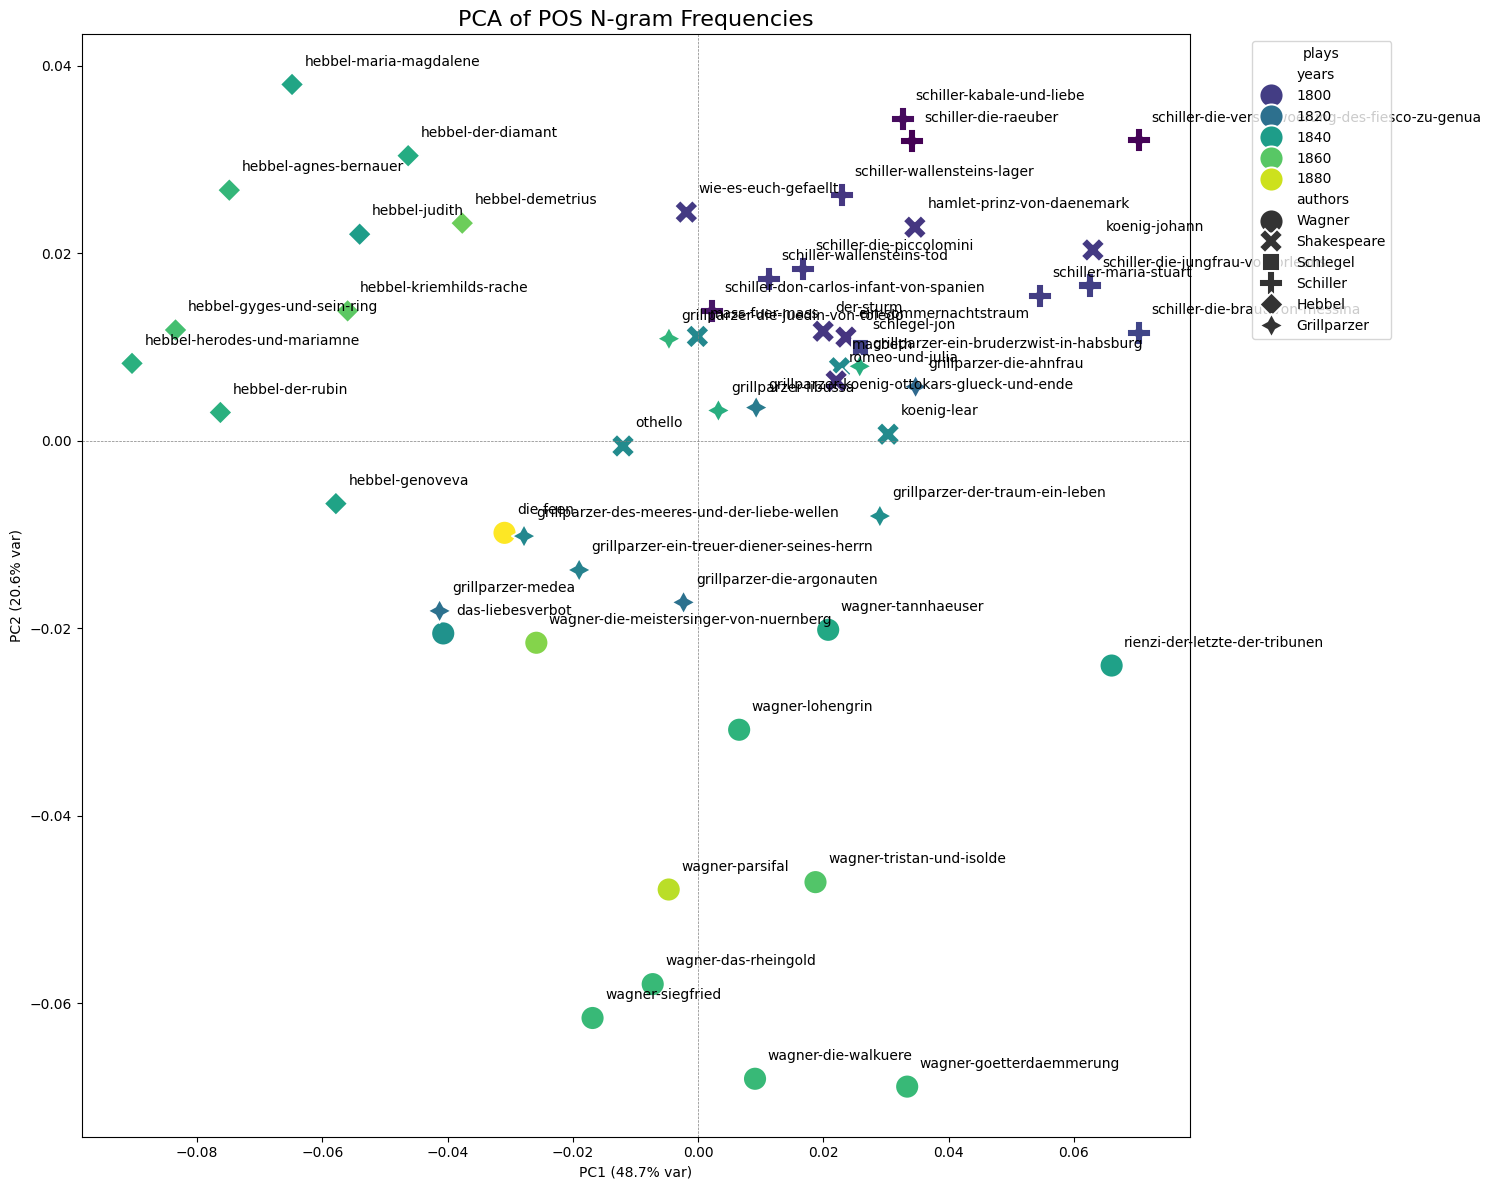

In [29]:

# ---------- 5. Scatter plot ----------
plt.figure(figsize=(15, 12))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="years",                # Color points by year
    palette="viridis",
    style='authors',
    
    s=300
)

# Add name labels for each point
for i, row in pca_df.iterrows():
    plt.text(
        row["PC1"] + 0.002,      # small horizontal offset
        row["PC2"] + 0.002,      # small vertical offset
        row["names"],            # column in pca_df with the play name
        fontsize=10,
        color="black"
    )


plt.title("PCA of POS N-gram Frequencies", fontsize=16)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.axhline(0, color="grey", linewidth=0.5, linestyle="--")
plt.axvline(0, color="grey", linewidth=0.5, linestyle="--")
plt.legend(title="plays", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

